In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_csv('trip_time_means.csv', index_col = 'pulocationid')
trip_time_data.columns = trip_time_data.columns.astype(int)

In [3]:
trip_time_data

,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
pulocationid,,,,,,,,,,,,,,,,,,,,,
1,19.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.540476,NaN,5.167347,43.009259,NaN,NaN,26.164216,NaN,21.255556,28.980556,...,8.283445,36.853333,50.141667,NaN,29.909524,12.957595,25.814583,36.427778,29.962821,31.922222
4,38.440143,NaN,36.005556,8.353476,39.816667,30.175000,25.623986,NaN,32.711111,34.955556,...,32.131944,17.887951,15.287944,21.346354,38.314286,31.405556,22.180637,14.926667,17.628817,18.310448
5,26.337016,NaN,NaN,NaN,6.377981,26.475439,NaN,NaN,NaN,63.383333,...,NaN,41.983333,NaN,NaN,NaN,NaN,NaN,45.066667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,51.784091,NaN,13.075407,41.887500,NaN,NaN,25.589524,NaN,NaN,34.687500,...,7.817611,38.598958,41.022222,66.283333,45.880392,5.406855,30.971930,50.381818,29.982639,29.974074
260,50.356373,NaN,29.951515,24.593915,NaN,NaN,9.541995,12.531944,21.596930,27.229938,...,28.170290,16.476681,17.322406,29.064583,26.097162,28.320238,6.141669,31.753922,23.707520,23.136458
261,38.053702,NaN,39.591667,14.067819,38.878571,22.952083,29.628744,NaN,35.214583,51.258974,...,39.840000,23.663167,21.626105,17.425219,40.557500,48.560000,26.953968,10.799706,22.717876,23.064069


In [4]:
from tqdm import tqdm

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    assert (zone_hourly_arrivals.index == zone_to_zone_times.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    for i in tqdm(zone_hourly_arrivals.index):
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        services = [np.random.exponential(mean) for mean in zone_service_times[arrival_df.dolocationid]]
                
        arrival_df['service'] = services
        
        zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

In [5]:
arrivals = generate_arrivals_per_zone()

100%|████████████████████████████████████████| 259/259 [00:01<00:00, 138.67it/s]


In [6]:
arrivals

,time,dolocationid,pulocationid,service
0,0.019354,97.0,67.0,23.093449
1,0.021564,148.0,231.0,9.265103
2,0.023128,36.0,225.0,25.857727
3,0.026410,161.0,230.0,17.226575
4,0.026645,154.0,150.0,19.871974
...,...,...,...,...
456701,1439.988897,17.0,37.0,3.247087
456702,1439.989873,182.0,76.0,43.910383
456703,1439.992261,177.0,49.0,8.525848
456704,1439.993641,100.0,198.0,178.367690


In [16]:
from collections import deque

#inserts event into queue, based on time
def insert_event(event, queue, time_index = -1):
    t = event[time_index]
        
    i = 0
    for e in queue:
        if t < e[time_index]:
            break
        i += 1
    queue.insert(i, event)

#assumes customer info mat is a dataframe with idx, time, pulocationid, dolocationid, service
def return_customer_info(idx, cust_info_mat = arrivals):
    sr = cust_info_mat.loc[idx]
    return idx, sr.time, sr.pulocationid, sr.dolocationid, sr.service
    
#generates a random movement time assuming service times are exponentially distributed
def generate_movement_time(pu, do, travel_times):
    
    #try except just catches the case where there's no pickup data for a zone
    try:
        mm = travel_times.loc[pu, do]
        if not pd.isnull(mm):
            mt = np.random.exponential(mm)
        else:
            #if there's no data for that specific pu->do, just use the mean of the pu zone trips
            mt = np.random.exponential(travel_times.loc[pu].mean())
    except:
        #if no data on that pickup zone, use the mean of the dropoff zone
        mt = np.random.exponential(travel_times.loc[:,do].mean())

    return mt

#update driver location (and where they are going), the drivers in each zone, and the number of drivers in each zone (if needed)
def update_driver_information(driver_id, dropoff_location, z_count_update, t, p,
                              d_locations, d_movements, z_drivers, z_counts):
    current_location = d_locations[driver_id]
    z_drivers[current_location].remove(driver_id)
    z_drivers[dropoff_location].add(driver_id)
    d_locations[driver_id] = dropoff_location
    
    d_movements[driver_id].append((t,dropoff_location,p))
    
    #if the driver leaves a location
    if z_count_update == -1:
        z_counts[current_location] -= 1
    
    #if the driver arrives at a location (and doesn't leave again)
    elif z_count_update == 1:
        z_counts[dropoff_location] += 1

def simulate_with_individual_drivers(arrivals, 
                                     driver_distribution = 'proportional',
                                     driver_count = 10000,
                                     odmatrix = trip_time_data,
                                     distributed_queue_count = 10, #speed option
                                    ):
    """event list: [
                   (driver id (-1 if customer arrival), 
                   (passenger id (-1 if no passenger),
                   (from location id, -1 if arrival),
                   (to location id, -1 if arrival),
                   (time of event (when the queue hits the event))
                   ]
       movement_queues essentially creates a bunch of queues to speed up inserting each created event into the event list
       can access the first event of each movement queue very quickly to check which queue to pop from
       the system also adds events to the minimum length queue to distribute the event load
    """
    negs = -1 * np.ones(arrivals.shape[0])
    arrival_queue = deque(np.c_[negs,
                             arrivals.index, 
                             negs,
                             negs,
                             arrivals.time])
    movement_queues = {i:deque() for i in range(distributed_queue_count)}
    
    #initialize driver queues
    driver_queues = {i:deque([]) for i in range(driver_count)}
    
    #initialize driver locations
    #in-between trip drivers have a value = -(zone where they are going to)
    #so -23 means the driver is going towards zone 23
    driver_locations = {}
    
    #to save the history of driver movements, save 
    #first the starting location (time = 0)
    #then each event afterwards:
    #1. time of movement 2. where they are / -where they going 3. customer id / -1
    driver_movements = {}
    
    #also keep track of the drivers in each zone (or on their way to each zone)
    zone_drivers = {i:set() for i in np.arange(-263, 264)}
    
    #for each zone, how many drivers are in there, not doing anything?
    zone_counts = {i:0 for i in np.arange(1,264)}
    
    #initialize passenger dep times
    passenger_departure_times = {}
    
    #assign driver locations
    """this driver assignment is flawed because it uses the arrivals, which you wouldn't actually know in real life
       a better way would be to just use the data previously gathered to generate driver distributions
       
       testing different distributions is also necessary for sensitivity analysis, so some ideas:
       1. distributing uniformly across all zones (obviously not the best strategy, but maybe a good baseline)
       2. place drivers in the top 10 most popular zones
       
       something to keep in mind this whole time though is that drivers are not the same as servers,
       uber's more of a platform and drivers can accept/reject trips and also have daily schedules for driving,
       adding an additional layer of complexity that probably needs to be added on later
    """
    if driver_distribution == 'proportional':
        
        #number of drivers per zone
        dcounts = driver_count * (arrivals.groupby('pulocationid')['time'].count() / arrivals.shape[0])
        dcounts = np.floor(dcounts)
        t = 0
        for i in dcounts.index:
            for d in range(int(dcounts.loc[i])):
                driver_locations[t] = i
                zone_drivers[i].add(t)
                driver_movements[t] = deque()
                driver_movements[t].appendleft((0,i,-1))
                t += 1
        #the remainder of drivers not included in the np.floor operation above get added randomly
        while t < driver_count:
            z = np.random.choice(np.arange(1,264))
            driver_locations[t] = z
            zone_drivers[z].add(t)
            driver_movements[t] = deque()
            driver_movements[t].appendleft((0,z,-1))
            t += 1
    
    #updating the number of drivers in each zone based on previous assignments
    for d in driver_locations:
        zone_counts[driver_locations[d]] += 1
    
    #for diagonising the system if there's any problems with speed
    stats = {}
    
    #progress bar based on the # of customers processed
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True)
    
    #second part of this conditional checks if any of the movement queues are of nonzero length
    while len(arrival_queue) > 0 or (np.array([len(i[1]) for i in movement_queues.items()]) > 0).any():
        
        """this entire bit is for speeding up the event list by adding several queues
        """
        #pick the minimum length movement queue to add to if needed 
        active_queue = min(movement_queues.keys(), key = lambda k: len(movement_queues[k]))
        active_queue = movement_queues[active_queue]
        
        #discover the first time value of each movement queue and the arrival queue (if the length is nonzero)
        first_times = [(k,v[0][-1]) if len(v) > 0 else (k,1000000) for k,v in movement_queues.items()]
        first_times.append(('a',arrival_queue[0][-1]) if len(arrival_queue) > 0 else ('a',1000000))
        
        #choose the right queue to take from based on the first times
        min_key = min(first_times, key = lambda i: i[1])
        if min_key[0] == 'a':
            event = arrival_queue.popleft()
        else:
            event = movement_queues[min_key[0]].popleft()
        
        
        #for interpretation purposes
        driver_id = int(event[0])
        pass_id = int(event[1])
        pickup = int(event[2])
        dropoff = int(event[3])
        etime = event[4]        
        
        #if passenger arrival
        if driver_id == -1:
            cust_id, pu_time, pu, do, serv = return_customer_info(pass_id)
            
            """driver selection
               pick a random driver in the beginning
               check if there's an available driver in the zone, break if there is
               otherwise it'll choose a driver coming towards the zone
               
               better version (not implemented):
               pick driver with lowest queue length out of the available ones
               pick drivers that are closest (would require more storage)
            """
            chosen_driver = np.random.randint(0, driver_count)
            drivers_coming_to_zone = tuple(zone_drivers[-1 * pu])
            drivers_in_zone = tuple(zone_drivers[pu])
            
            if len(drivers_in_zone) > 0:
                chosen_driver = np.random.choice(drivers_in_zone)
                #if the customer is in the zone, then immediately generate the departure event
                departure_event = np.array([chosen_driver,
                                            cust_id,
                                            pu,
                                            do,
                                            pu_time + serv])
                insert_event(departure_event, active_queue)
                update_driver_information(chosen_driver, -1 * do, -1, pu_time, cust_id,
                                          driver_locations, driver_movements, zone_drivers, zone_counts)
                                        
            else: #add to the chosen driver's queue, make the driver move if the driver is free
                
                if len(drivers_coming_to_zone) > 0:
                    chosen_driver = np.random.choice(drivers_coming_to_zone)
                
                driver_queues[chosen_driver].append(cust_id)
                
                d_loc = driver_locations[chosen_driver]
                if d_loc > 0:
                    #generate a driver movement event
                    move_time = generate_movement_time(d_loc, pu, odmatrix)
                    movement_event = np.array([chosen_driver,
                                               -1,
                                               d_loc,
                                               pu,
                                               pu_time + move_time])
                    insert_event(movement_event, active_queue)
                    update_driver_information(chosen_driver, -1 * pu, -1, pu_time, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts)
                
        #anything else involves a driver
        else:
            
            #if passenger departure
            if pass_id != -1:
                #first record the departure
                passenger_departure_times[pass_id] = etime
                pbar.update(1)
                
                #deal with driver's queued customer
                if len(driver_queues[driver_id]) > 0:
                    
                    next_customer = driver_queues[driver_id][0]
                    cust_id, pu_time, pu, do, serv = return_customer_info(next_customer)
                    
                    #if the queued customer is in the current zone
                    if pu == dropoff:
                        #add a departure event
                        driver_queues[driver_id].popleft()
                        departure_event = np.array([driver_id,
                                                    cust_id,
                                                    pu,
                                                    do,
                                                    etime + serv])
                        insert_event(departure_event, active_queue)
                        update_driver_information(driver_id, -1 * do, 0, etime, cust_id,
                                                  driver_locations, driver_movements, zone_drivers, zone_counts)
                        
                    else:
                        #add a driver movement event
                        move_time = generate_movement_time(dropoff, pu, odmatrix)
                        movement_event = np.array([driver_id,
                                                   -1,
                                                   dropoff,
                                                   pu,
                                                   etime + move_time])
                        insert_event(movement_event, active_queue)
                        update_driver_information(driver_id, -1 * pu, 0, etime, -1,
                                                  driver_locations, driver_movements, zone_drivers, zone_counts)
                
                else:
                    """if no queued customer, just leave the driver at the zone they went to
                
                    a more realistic algorithm would be to move the driver towards anticipated demand
                    """
                    update_driver_information(driver_id, dropoff, 1, etime, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts)       
            
            #if driver only movement
            else:
                
                #deal with queued customer who will always be in the zone
                if len(driver_queues[driver_id]) > 0:
                    
                    next_customer = driver_queues[driver_id].popleft()
                    cust_id, pu_time, pu, do, serv = return_customer_info(next_customer)
                    
                    departure_event = np.array([driver_id,
                                                cust_id,
                                                dropoff,
                                                do,
                                                etime + serv])
                    insert_event(departure_event, active_queue)
                    update_driver_information(driver_id, -1 * do, 0, etime, cust_id,
                                              driver_locations, driver_movements, zone_drivers, zone_counts)
                    
                else:
                    """if no queued customer, just leave the driver at the zone they went to
                
                   a more realistic algorithm would be to move the driver towards anticipated demand
                    """  
                    update_driver_information(driver_id, dropoff, 1, etime, -1,
                                              driver_locations, driver_movements, zone_drivers, zone_counts)
                     
                
    pbar.close()
    
    return passenger_departure_times, driver_movements


In [53]:
arrival_partition = arrivals

customer_departures = simulate_with_individual_drivers(arrival_partition, driver_count = 25000, distributed_queue_count = 50)

100%|█████████████████████████████████| 456706/456706 [02:02<00:00, 3715.46it/s]


In [48]:
wait_times = (pd.Series(customer_departures[0]).sort_index() - arrival_partition.time - arrival_partition.service).round(3)

In [49]:
print(wait_times.mean())


64.69070491081789


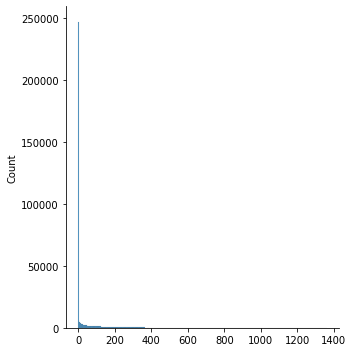

In [50]:
import seaborn as sns

sns.displot(wait_times)


In [51]:
import sys

#recursive get size of the driver movements
s = sys.getsizeof(customer_departures[1])
for k,v in customer_departures[1].items():
    s += sys.getsizeof(v)
    s += sum([sys.getsizeof(t) for t in v])
    s += sum([sum([sys.getsizeof(i) for i in t]) for t in v])
print(s / 1024 ** 3)

0.13584905862808228


In [54]:
from joblib import dump

dump(customer_departures[1], 'sample_driver_movements_1_day')

['sample_driver_movements_1_day']